In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM, BatchNormalization,SimpleRNN
from keras import Input
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

[]

In [ ]:
DataPath=  '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/RML2016.10b.dat' #'/content/drive/MyDrive/ModulationClassification/RML2016.10b.dat'

In [ ]:
pickle_in = open(DataPath,"rb")
data = pickle.load(pickle_in, encoding="bytes")

In [ ]:
def load_data(data):
  s = np.empty((0,128,2))
  l=np.array([])
  for key in data.keys():
    # load samples
    x,y=key
    x = x.decode('ascii')
    samples = np.array(data.get(key)).transpose(0, 2, 1)
    # create labels
    labels = np.repeat(x+'_'+str(y),samples.shape[0])
    l=np.concatenate([l,labels])
    s=np.vstack((s,samples))
    print('key',key)
    print("samples:",samples.shape)
    print('labels',labels.shape)
  return l,s,data.keys()
  

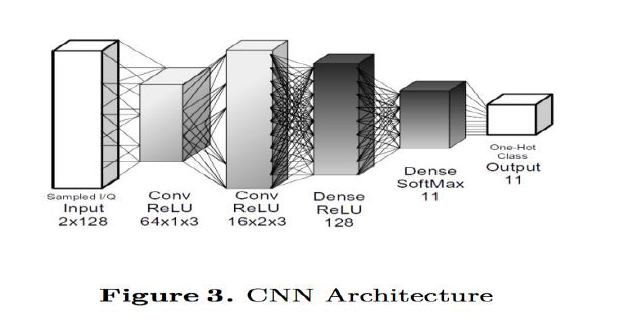

In [ ]:
def first_drev(data):
  drev = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = np.gradient(data[i*6000:i*6000+6000][:][:],axis=1)
    drev=np.vstack((drev,tmp))
    del tmp
  return drev


In [ ]:
def integral(data):
  data=np.pad(data, [(0, 0),(0,0),(0,1)], 'constant')
  integral = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = scipy.integrate.cumtrapz(data[i*6000:i*6000+6000][:][:],dx=1)
    integral=np.vstack((integral,tmp))
    del tmp
  return integral

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def create_model():
  number_of_channels = 2 
  vanilla_rnn_model = Sequential()
  vanilla_rnn_model.add(Input(shape=(128,number_of_channels)))
  vanilla_rnn_model.add(SimpleRNN(128))
  vanilla_rnn_model.add(Dense(10, activation='softmax'))
  
  return vanilla_rnn_model  

In [ ]:
labels, samples,classes = load_data(data)

key (b'QPSK', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'AM-DSB', -4)
samples: (6000, 128, 2)
labels (6000,)
key (b'GFSK', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', 18)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM64', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', 2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QAM16', -20)
samples: (6000, 128, 2)
labels (6000,)
key (b'8PSK', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'PAM4', -6)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', -18)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 8)
samples: (6000, 128, 2)
labels (6000,)
key (b'CPFSK', 10)
samples: (6000, 128, 2)
labels (6000,)
key (b'WBFM', 6)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', 4)
samples: (6000, 128, 2)
labels (6000,)
key (b'BPSK', -2)
samples: (6000, 128, 2)
labels (6000,)
key (b'QPSK', -20)
samples: (

In [ ]:
# to encode the labels
lb = LabelEncoder()

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)
del samples
del labels
# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))

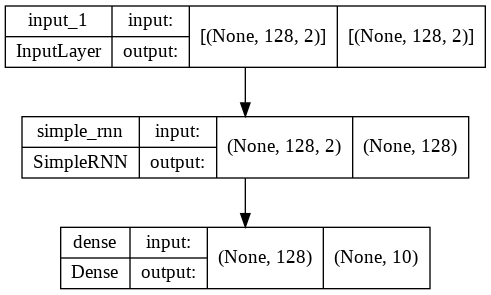

In [ ]:
# create model
model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])

# Save an image of the model's architecture to a file
plot_model(model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

Epoch 1/25
12469/12469 [==============================] - 614s 49ms/step - loss: 2.1310 - accuracy: 0.1667 - val_loss: 1.9587 - val_accuracy: 0.2187
Epoch 2/25
12469/12469 [==============================] - 626s 50ms/step - loss: 1.9089 - accuracy: 0.2425 - val_loss: 1.8560 - val_accuracy: 0.2650
Epoch 3/25
12469/12469 [==============================] - 632s 51ms/step - loss: 1.8473 - accuracy: 0.2688 - val_loss: 1.7803 - val_accuracy: 0.2854
Epoch 4/25
12469/12469 [==============================] - 632s 51ms/step - loss: 1.7453 - accuracy: 0.3005 - val_loss: 1.6882 - val_accuracy: 0.3177
Epoch 5/25
12469/12469 [==============================] - 630s 51ms/step - loss: 1.6865 - accuracy: 0.3199 - val_loss: 1.6823 - val_accuracy: 0.3191
Epoch 6/25
12469/12469 [==============================] - 630s 51ms/step - loss: 1.6676 - accuracy: 0.3263 - val_loss: 1.6667 - val_accuracy: 0.3280
Epoch 7/25
12469/12469 [==============================] - 633s 51ms/step - loss: 1.6248 - accuracy: 0.3382

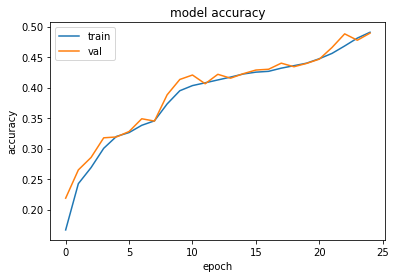

3858

In [ ]:
#training on best learning rate which is 1e-5
gc.collect()
model = create_model()
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

# train model
cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 25,batch_size=64,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb))
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/rnn/raw_model.h5')

# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
gc.collect()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/cnn/raw_model.h5')
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.4910416603088379


In [ ]:
# train accuracy
score = model.evaluate(x_train, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

Training Accuracy:  0.49128445982933044


In [ ]:
del x_train
del y_train
del y_val
del x_val
del y_train_lb
del y_val_lb
gc.collect()

701

In [ ]:
# to get confusion matrix

y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)
classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')


In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',16918,1700,2511,702,1228,2590,1258,1676,6461,956
b'AM-DSB',1397,18521,1344,317,1265,942,106,20,1246,10842
b'BPSK',2518,1625,22511,402,1052,3766,409,242,2503,972
b'CPFSK',2893,1703,2185,21199,1212,2356,609,331,2496,1016
b'GFSK',2463,2114,2049,1318,21397,2247,336,104,1960,2012
b'PAM4',1706,1244,2332,282,733,26476,309,488,1663,767
b'QAM16',2433,1041,1594,436,682,2449,1601,23067,2113,584
b'QAM64',1760,663,1089,306,479,2214,1392,26173,1541,383
b'QPSK',13609,1555,2564,704,1182,2676,1218,1595,9910,987
b'WBFM',1505,14438,1355,351,3821,974,143,28,1316,12069


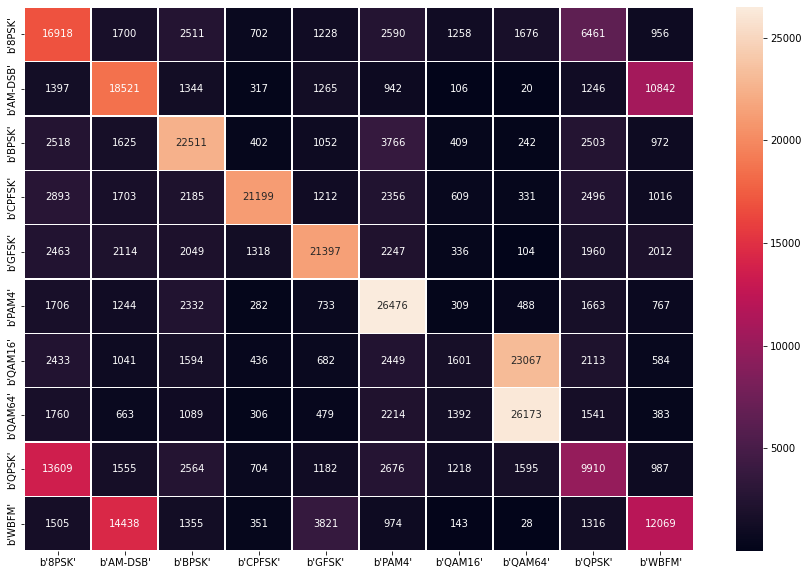

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.4788510159749351
Recall:  0.4910416666666667
F-score:  0.47206626498023024


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.68,11.26,12.32,14.1,21.18,29.08,32.23,35.38,48.65,60.62,66.95,69.92,70.34,71.0,71.41,71.09,71.04,72.14,70.73,71.93


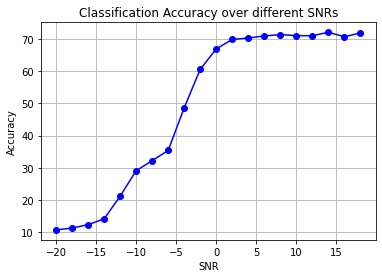

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)